In [1]:
import pandas as pd
import numpy as np
import copy
import scipy.stats
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('energy_efficiency.csv')

In [2]:
df.columns = ['RelativeCompactness', 'SurfaceArea', 'WallArea', 'RoofArea', 'OverallHeight', 'Orientation', \
              'GlazingArea', 'GlazingAreaDistribution', 'HeatingLoad', 'CoolingLoad']
df.columns

Index(['RelativeCompactness', 'SurfaceArea', 'WallArea', 'RoofArea',
       'OverallHeight', 'Orientation', 'GlazingArea',
       'GlazingAreaDistribution', 'HeatingLoad', 'CoolingLoad'],
      dtype='object')

# Nedostajuće vrijednosti

In [3]:
df.isnull().sum()

RelativeCompactness        0
SurfaceArea                0
WallArea                   0
RoofArea                   0
OverallHeight              0
Orientation                0
GlazingArea                0
GlazingAreaDistribution    0
HeatingLoad                0
CoolingLoad                0
dtype: int64

# Distribucija varijabli

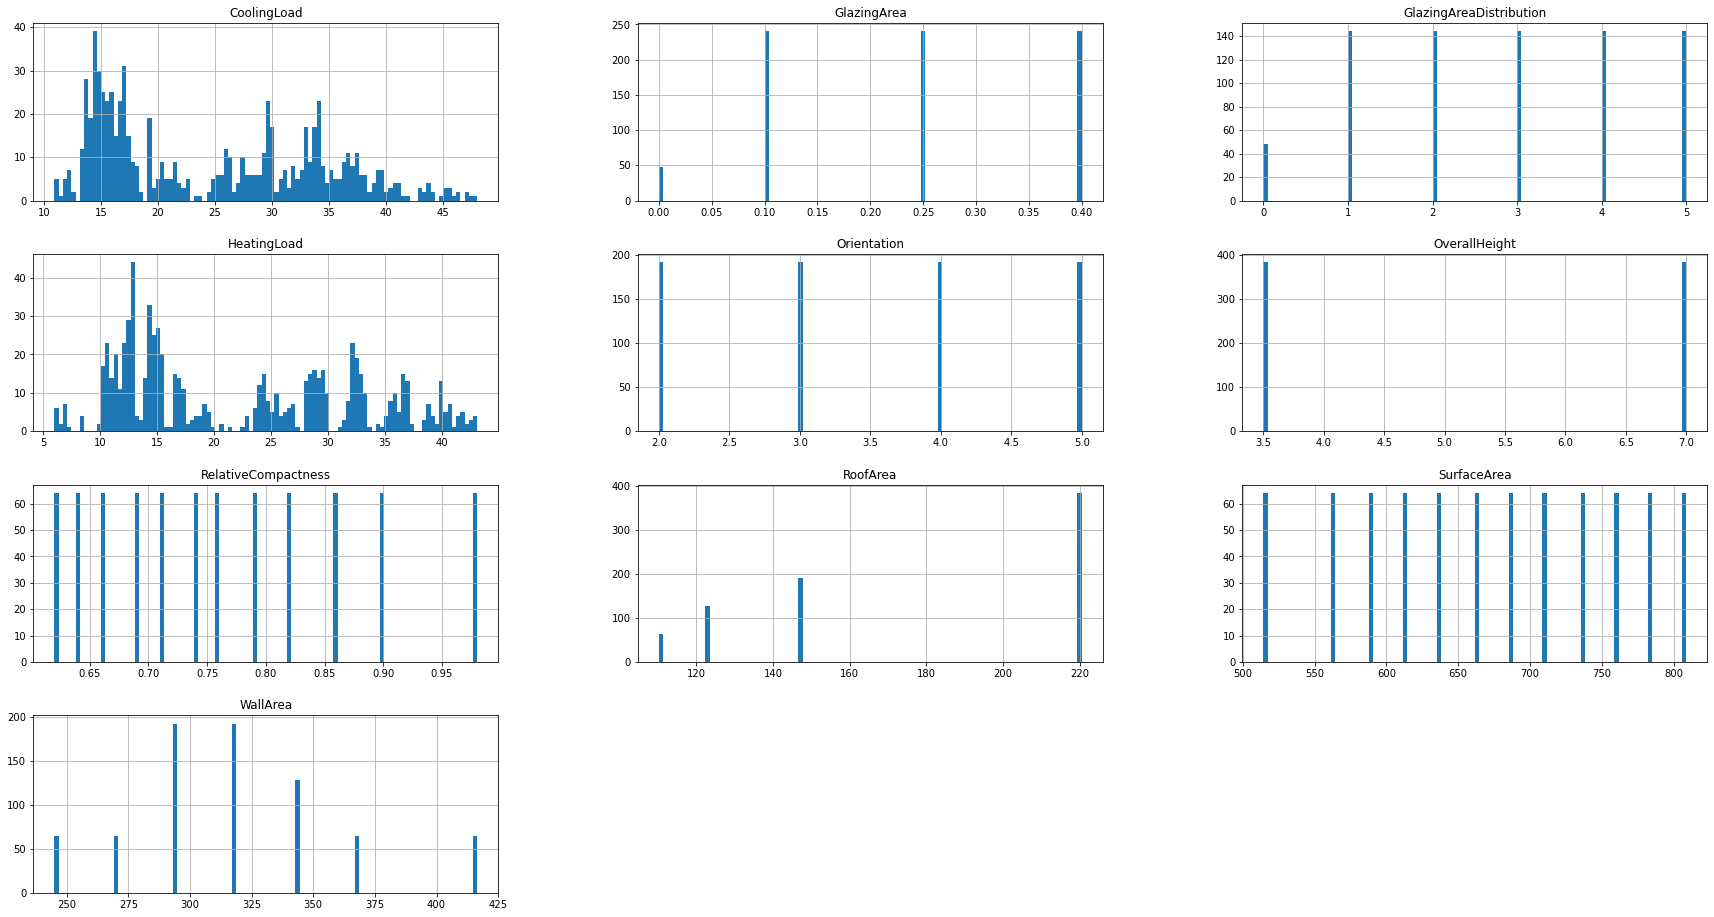

In [4]:
df.hist(figsize=(30,16), bins=100)
plt.show()

# Ekstremne vrijednosti

In [5]:
def contains_outliers(x):
    import seaborn as sns
    """
    Returns bool
    Prints which continous variables contain
    param x: DataFrame object
    """
    df_new = df.select_dtypes(exclude=[np.object, np.bool, np.datetime64])
    cols = df_new.columns
    cols_with_outliers = set()
    for col in cols:
        mean = np.mean(df_new[col])
        std = np.std(df_new[col])
        for value in df_new[col].values:
            z_score = (value - mean) / std
            if z_score < -3 or z_score > 3:
                cols_with_outliers.add(col)
    
    if cols_with_outliers:
        for col in cols_with_outliers:
            print(f"{col} contains outliers")
            sns.boxplot(x=df_new[col])
        return True
    else:
        return False

In [6]:
contains_outliers(df)

False

In [7]:
df['potrosnja'] = df.apply(lambda x: round(np.mean([x['HeatingLoad'], x['CoolingLoad']]), 2) , axis=1)

In [8]:
potrosnja = list(df['potrosnja'])
potrosnja.sort(reverse=False)
potrosnja = potrosnja[:round(len(potrosnja)*0.35)]
#print(potrosnja)
kriterij = potrosnja[-1]
print('Potrošnja <= {0} smatrat će se učinkovitom.'.format(kriterij))

df['ciljna'] = False
df.loc[df.potrosnja <= kriterij, 'ciljna'] = True 
df.head(10)
učinkoviti = df.ciljna.loc[df.ciljna == True].count()
print('Postoji {0} zgrada prema ovom kriteriju.'.format(učinkoviti))

Potrošnja <= 15.81 smatrat će se učinkovitom.
Postoji 269 zgrada prema ovom kriteriju.


# Logistička regresija

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import random

In [10]:
train = df[['RoofArea', 'GlazingArea', 'WallArea', 'ciljna']]
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [11]:
regression = LogisticRegression(fit_intercept=True)
regression.fit(X_train, y_train)

training_pred = regression.predict(X_train)
print('Prediktivnost na training uzorku: {:.2f}%'.format(regression.score(X_train, y_train) * 100))
testing_pred = regression.predict(X_test)
print('Prediktivnost na testing uzorku: {:.2f}%'.format(regression.score(X_test, y_test) * 100))

Prediktivnost na training uzorku: 86.64%
Prediktivnost na testing uzorku: 91.56%


# Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

training_pred = dtc.predict(X_train)
accu = metrics.accuracy_score(y_train, training_pred)
print(f"Prediktivnost na training uzorku: {accu}")
testing_pred = dtc.predict(X_test)
accu = metrics.accuracy_score(y_test, testing_pred)
print(f"Prediktivnost na testing uzorku: {accu}")

Prediktivnost na training uzorku: 0.9771986970684039
Prediktivnost na testing uzorku: 0.9935064935064936


In [14]:
from sklearn.tree import plot_tree

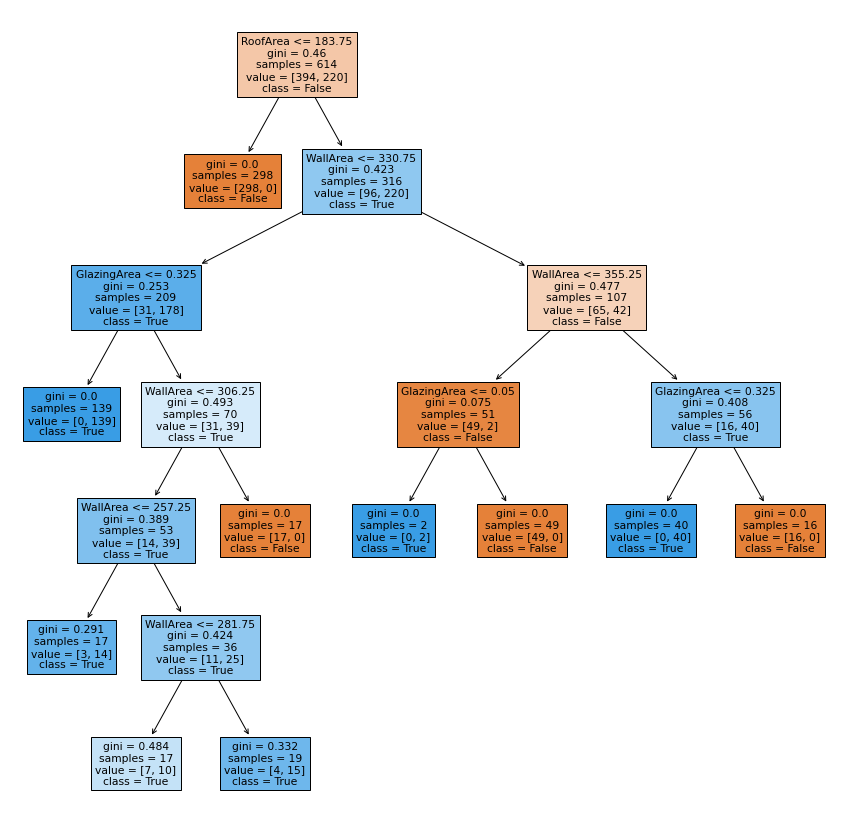

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(dtc, class_names=["False", "True"], filled=True, feature_names=X_train.columns)
plt.savefig('tree.png',format='png',bbox_inches = "tight")

# SVM classifier

In [16]:
from sklearn.svm import SVC

In [17]:
svc = SVC()
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
accu = metrics.accuracy_score(y_train, pred_train)
print(f"Prediktivnost na training uzorku: {accu}")

pred_test = svc.predict(X_test)
accu = metrics.accuracy_score(y_test, pred_test)
print(f"Prediktivnost na testing uzorku: {accu}")

Prediktivnost na training uzorku: 0.8436482084690554
Prediktivnost na testing uzorku: 0.8766233766233766


In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
accu = metrics.accuracy_score(y_train, pred_train)
print(f"Prediktivnost na training uzorku: {accu}")

pred_test = rfc.predict(X_test)
accu = metrics.accuracy_score(y_test, pred_test)
print(f"Prediktivnost na testing uzorku: {accu}")

Prediktivnost na training uzorku: 0.9771986970684039
Prediktivnost na testing uzorku: 0.9935064935064936


In [20]:
import pickle

In [21]:
model_filename = "model.pickle"

In [22]:
pickle.dump(dtc, open(model_filename, 'wb'))